In [ ]:
import math
import random
from collections import Counter, defaultdict
from tqdm.notebook import tqdm, trange
import statbotics
import matplotlib.pyplot as plt
from enum import Enum
from typing import NamedTuple, TypedDict, Literal, NotRequired
from functools import total_ordering
import numpy
import scipy
from tba_types import Team, Event, TeamEventOPR, OPRs, DistrictPoints
from tba_session import session, ROOT_URL

sb = statbotics.Statbotics()

In [2]:
# Values all negative so sort in descending order goes winner -> ... -> not picked
@total_ordering
class PlayoffFinish(Enum):
    NOT_PICKED = 0

    # Double Elimination
    SEVENTH_EIGHTH = 2
    FIFTH_SIXTH = 3
    FOURTH = 4
    THIRD = 5

    # Bracket / Avg Score
    EIGHTHFINALIST = 1
    QUARTERFINLIST = 2
    SEMIFINALIST = 4

    # Every kind
    FINALIST = 6
    WINNER = 7

    def __lt__(self, other):
        if self.__class__ is not other.__class__:
            return NotImplemented
        return self.value < other.value


class SortingCriteria(NamedTuple):
    points: int
    best_playoff_finish: PlayoffFinish
    best_alliance_selection: int
    best_quals_performance: int
    highest_score: int
    second_highest_score: int
    third_highest_score: int
    random_val: float

Change stuff in this:

In [ ]:
YEAR = 2024

CAPACITY = 600  # worlds capacity

IMPACT_AWARD_KEY = 0
EI_KEY = 9

TEAM_PAGES = 2  # 1 page = 500 teams

STATBOTICS_PAGES = 4  # 1 page = 1000 teams

In [ ]:
EVENTS: list[Event] = session.get(ROOT_URL + f"/events/{YEAR}").json()
LAST_YEAR_EVENTS: list[Event] = session.get(ROOT_URL + f"/events/{YEAR-1}").json()

ALL_TEAMS: dict[str, Team] = {}

for page in trange(TEAM_PAGES, desc="Getting Teams", total=TEAM_PAGES, leave=False):
    team: Team
    for team in session.get(ROOT_URL + f"/teams/{YEAR}/{page}").json():
        ALL_TEAMS[team["key"]] = team

ALL_TEAM_KEYS = set(ALL_TEAMS.keys())

hof = {
    1992: [191],
    1994: [191],
    1995: [151], 
    1996: [144], 
    1997: [47], 
    1998: [23], 
    1999: [120], 
    2000: [16], 
    2001: [22],
    2002: [175],
    2003: [103],
    2004: [254],
    2005: [67],
    2006: [111],
    2007: [365],
    2008: [842],
    2009: [236],
    2010: [341],
    2011: [359],
    2012: [1114],
    2013: [1538],
    2014: [27],
    2015: [597],
    2016: [987],
    2017: [3132, 2614],
    2018: [1311, 2834],
    2019: [1902, 1816],
    2021: [503, 4613],
    2022: [1629],
    2023: [321],
    2024: [2486]
}

PREQUALIFIED = {
    "frc" + str(team)
    for team in {num for y in range(YEAR - 8 if YEAR < 2020 else YEAR - 9, YEAR) if y in hof for num in hof[y]}
}

last_year = YEAR - 9 if YEAR < 2020 else YEAR - 10

while not all(num in ALL_TEAM_KEYS for num in PREQUALIFIED):
    PREQUALIFIED.remove(next(num for num in PREQUALIFIED if num not in ALL_TEAM_KEYS))
    while last_year not in hof:
        last_year -= 1
    PREQUALIFIED.add("frc" + str(hof[last_year][0]))

TEAM_TO_EPA: dict[str, float] = {}

for i in range(STATBOTICS_PAGES):
    for team_year in sb.get_team_years(year=YEAR, limit=1000, offset=i * 1000):
        TEAM_TO_EPA[f"frc{team_year['team']}"] = team_year["epa"]["norm"]

TEAM_TO_EPA_LAST_YEAR: dict[str, float] = {}

for i in range(STATBOTICS_PAGES):
    for team_year in sb.get_team_years(year=YEAR-1, limit=1000, offset=i * 1000):
        TEAM_TO_EPA_LAST_YEAR[f"frc{team_year['team']}"] = team_year["epa"]["norm"]

TOTAL_TEAMS = len(TEAM_TO_EPA)

DISTRICT_TEAMS: set[str] = set()

REGIONALS = len([event for event in EVENTS if event["event_type"] == 0])

regional_capacity = CAPACITY - len(PREQUALIFIED)

for district in tqdm({"fma", "pnw", "pch", "fim", "fin", "fit", "ne", "chs", "fnc", "ont", "isr", "fsc"}, desc="Getting District Teams", leave=False):
    team_keys: set[str] = set(session.get(ROOT_URL + f"/district/{YEAR}{district}/teams/keys").json())
    regional_capacity -= math.ceil(len(team_keys & ALL_TEAM_KEYS) / TOTAL_TEAMS * CAPACITY)
    DISTRICT_TEAMS.update(team_keys)

ACTUAL_WORLDS_TEAMS = set() # {"frc4738", "frc870", "frc1561", "frc4143", "frc1730", "frc7567", "frc3045", "frc1847", "frc8595", "frc1986", "frc6665", "frc4655", "frc5736", "frc1732", "frc5013", "frc4322", "frc7433", "frc10291", "frc9484", "frc4646", "frc8214", "frc4122", "frc4500", "frc3492", "frc3100", "frc8503", "frc10120", "frc9576", "frc1671", "frc3006", "frc5968", "frc6706", "frc7522", "frc5526", "frc5847", "frc971", "frc801", "frc2228", "frc10598", "frc1507", "frc1468", "frc4005", "frc9301", "frc1329", "frc5800", "frc5298", "frc3544"}

for event in filter(lambda event: event["event_type"] == 3 or event["event_type"] == 4, EVENTS):
    ACTUAL_WORLDS_TEAMS.update(session.get(ROOT_URL + f"/event/{event['key']}/teams/keys").json())

ACTUAL_WORLDS_TEAMS_LAST_YEAR = set()

for event in filter(lambda event: event["event_type"] == 3 or event["event_type"] == 4, LAST_YEAR_EVENTS):
    ACTUAL_WORLDS_TEAMS_LAST_YEAR.update(session.get(ROOT_URL + f"/event/{event['key']}/teams/keys").json())

WORLDS_REGIONAL_TEAMS = ACTUAL_WORLDS_TEAMS - DISTRICT_TEAMS
WORLDS_REGIONAL_TEAMS_LAST_YEAR = ACTUAL_WORLDS_TEAMS_LAST_YEAR - DISTRICT_TEAMS

Getting Teams:   0%|          | 0/22 [00:00<?, ?it/s]

Getting District Teams:   0%|          | 0/12 [00:00<?, ?it/s]

## Week 1 Events
### Brazil Regional
frc7565 - 89
frc1156 - 73
frc7567 - 64
### Canadian Pacific Regional
frc1622 - 76
frc359 - 73
frc4270 - 72
### Festival de Robotique Regional
frc3990 - 112
frc7605 - 73
frc3544 - 63
### Greater Pittsburgh Regional
frc4611 - 69
frc325 - 66
frc144 - 51
### Hueneme Port Regional
frc498 - 81
frc4481 - 71
frc3647 - 63
### Lake Superior Regional
frc1732 - 73
frc2052 - 71
frc8298 - 52
### Northern Lights Regional
frc6147 - 68
frc4230 - 65
frc6574 - 63
### Regional Monterrey presented by PrepaTec
frc4400 - 82
frc7421 - 71
frc4403 - 70
### Silicon Valley Regional
frc1678 - 112
frc581 - 68
frc604 - 58
### Smoky Mountains Regional
frc7428 - 78
frc801 - 73
frc4020 - 72
### South Florida Regional
frc108 - 77
frc179 - 73
frc180 - 72
### Utah Regional
frc1410 - 64
frc1339 - 63
frc7426 - 61
## Week 2 Events
### Arkansas Regional
frc16 - 73
frc3937 - 72
frc2341 - 63
### Bosphorus Regional
frc9483 - 69
frc8570 - 61
frc6459 - 60
### Central Missouri Regional
frc1706 -

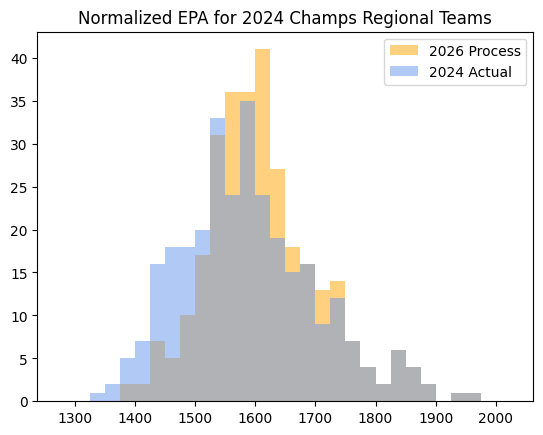

In [ ]:
qualified_teams: set[str] = set()

regional_pool: dict[str, tuple[int] | tuple[int, int]] = {}

REGIONAL_POOL_SIZE = regional_capacity - REGIONALS * 3

best_playoff_finish: dict[str, PlayoffFinish] = defaultdict(
    lambda: PlayoffFinish.NOT_PICKED
)
best_alliance_points: dict[str, int] = defaultdict(int)
best_quals_performance: dict[str, int] = defaultdict(int)
scores: dict[str, list[int]] = defaultdict(list)
events_by_team: dict[str, list[TeamEventOPR]] = defaultdict(list)


def regional_pool_points(events: tuple[int] | tuple[int, int], team_key: str) -> int:
    points = 0
    if ALL_TEAMS[team_key]["rookie_year"] == YEAR:
        points += 10
    elif ALL_TEAMS[team_key]["rookie_year"] == YEAR - 1:
        points += 5
    if len(events) == 2:
        return points + events[0] + events[1]
    return points + round(events[0] * 1.6) + 14


def sorting_criteria(team_key: str, points: int) -> SortingCriteria:
    return SortingCriteria(
        points,
        best_playoff_finish[team_key],
        best_alliance_points[team_key],
        best_quals_performance[team_key],
        *sorted(scores[team_key], reverse=True)[:3],
        random.random(),
    )


def pool_sorting_criteria(team_key: str) -> SortingCriteria:
    return sorting_criteria(team_key, regional_pool_points(regional_pool[team_key], team_key))


event_thresholds_by_week = []
pool_thresholds = []
team_last_week: dict[str, int] = {}
team_qualified_from: dict[str, str | tuple[str, str]] = {}

for week in range(1, 7):
    print("## Week", week, "Events")
    event_thresholds = []
    for event in sorted(
        filter(
            lambda event: event["week"] == week - 1 and event["district"] is None,
            EVENTS,
        ),
        key=lambda event: event["name"],
    ):
        print("###", event["name"])
        this_event_teams: dict[str, int] = {}
        event_key = event["key"]
        district_points: DistrictPoints = session.get(
            f"{ROOT_URL}/event/{event_key}/district_points"
        ).json()
        awards = session.get(
            f"{ROOT_URL}/event/{event_key}/awards"
        ).json()
        oprs: OPRs = session.get(
            f"{ROOT_URL}/event/{event_key}/oprs"
        ).json()
        for team_key, points in district_points["points"].items():
            if team_key in DISTRICT_TEAMS:
                continue
            team_last_week[team_key] = week
            best_alliance_points[team_key] = max(
                points["alliance_points"], best_alliance_points[team_key]
            )
            best_quals_performance[team_key] = max(
                points["qual_points"], best_quals_performance[team_key]
            )
            points = points["total"]
            if list(
                filter(
                    lambda award: award["award_type"] == IMPACT_AWARD_KEY
                    and award["recipient_list"][0]["team_key"] == team_key,
                    awards,
                )
            ):
                points += 45 - 10
            if list(
                filter(
                    lambda award: award["award_type"] == EI_KEY
                    and award["recipient_list"][0]["team_key"] == team_key,
                    awards,
                )
            ):
                points += 28 - 8
            events_by_team[team_key].append(TeamEventOPR(team_key, event_key, oprs["oprs"][team_key], week, points))
            if team_key in qualified_teams or team_key in PREQUALIFIED:
                continue
            this_event_teams[team_key] = points
            if team_key not in regional_pool:
                regional_pool[team_key] = (points,)
            elif len(regional_pool[team_key]) == 1:
                regional_pool[team_key] = (regional_pool[team_key][0], points)
        for team_key, tiebreakers in district_points["tiebreakers"].items():
            scores[team_key].extend(tiebreakers.get("highest_qual_scores", []))
        for team_key, status in (
            session.get(
                ROOT_URL + f"/event/{event_key}/teams/statuses"
            )
            .json()
            .items()
        ):
            playoff_finish = PlayoffFinish.NOT_PICKED
            if status is not None and "playoff" in status:
                match status["playoff"]:
                    case {
                        "playoff_type": 10,
                        "double_elim_round": "Finals",
                        "status": "won",
                    }:
                        playoff_finish = PlayoffFinish.WINNER
                    case {
                        "playoff_type": 10,
                        "double_elim_round": "Finals",
                        "status": "eliminated",
                    }:
                        playoff_finish = PlayoffFinish.FINALIST
                    case {"playoff_type": 10, "double_elim_round": "Round 5"}:
                        playoff_finish = PlayoffFinish.THIRD
                    case {"playoff_type": 10, "double_elim_round": "Round 4"}:
                        playoff_finish = PlayoffFinish.FOURTH
                    case {"playoff_type": 10, "double_elim_round": "Round 3"}:
                        playoff_finish = PlayoffFinish.FIFTH_SIXTH
                    case {"playoff_type": 10, "double_elim_round": "Round 2"}:
                        playoff_finish = PlayoffFinish.SEVENTH_EIGHTH
                    case {
                        "playoff_type": 11,
                        "double_elim_round": "Finals",
                        "status": "won",
                    }:
                        playoff_finish = PlayoffFinish.WINNER
                    case {
                        "playoff_type": 11,
                        "double_elim_round": "Finals",
                        "status": "eliminated",
                    }:
                        playoff_finish = PlayoffFinish.FINALIST
                    case {"playoff_type": 11, "double_elim_round": "Round 3"}:
                        playoff_finish = PlayoffFinish.THIRD
                    case {"playoff_type": 11, "double_elim_round": "Round 2"}:
                        playoff_finish = PlayoffFinish.FOURTH
                    case {"level": "f", "status": "won"}:
                        playoff_finish = PlayoffFinish.WINNER
                    case {"level": "f", "status": "eliminated"}:
                        playoff_finish = PlayoffFinish.FINALIST
                    case {"level": "sf"}:
                        playoff_finish = PlayoffFinish.SEMIFINALIST
                    case {"level": "qf"}:
                        playoff_finish = PlayoffFinish.QUARTERFINLIST
                    case {"level": "ef"}:
                        playoff_finish = PlayoffFinish.EIGHTHFINALIST
            best_playoff_finish[team_key] = max(
                playoff_finish, best_playoff_finish[team_key]
            )
        event_threshold = 0
        for team_key in list(
            sorted(
                this_event_teams.keys(),
                key=lambda key: sorting_criteria(key, this_event_teams[key]),
                reverse=True,
            )
        )[:3]:
            qualified_teams.add(team_key)
            if team_key in regional_pool:
                del regional_pool[team_key]
            print(team_key, "-", this_event_teams[team_key])
            event_threshold = this_event_teams[team_key]
            team_qualified_from[team_key] = event_key
        event_thresholds.append(event_threshold)
    if week > 1:
        print("### Week", week, "Regional Pool")
        TO_QUALIFY = REGIONAL_POOL_SIZE // (7 - week)
        REGIONAL_POOL_SIZE -= TO_QUALIFY
        pool_threshold = 0
        for team_key in list(
            sorted(
                regional_pool.keys(),
                key=lambda key: pool_sorting_criteria(key),
                reverse=True,
            )
        )[:TO_QUALIFY]:
            qualified_teams.add(team_key)
            print(
                team_key, "-", points := regional_pool_points(regional_pool[team_key], team_key)
            )
            pool_threshold = points
            events = events_by_team[team_key]
            if len(events) == 1:
                team_qualified_from[team_key] = events[0].event
            else:
                team_qualified_from[team_key] = (events[0].event, events[1].event)
            del regional_pool[team_key]
        pool_thresholds.append(pool_threshold)
    event_thresholds_by_week.append(event_thresholds)

counter = Counter()

for team_key in qualified_teams:
    counter[team_last_week[team_key]] += 1

print("## Qualifying Teams by Week of Last Event:")
for week, count in sorted(counter.items()):
    print("Week", week, ":", count)

print("## Thresholds")
for week, event_thresholds in enumerate(event_thresholds_by_week, start=1):
    print("### Week", week, "Event Thresholds:")
    print(scipy.stats.describe(event_thresholds))
print("### Pool Thresholds:")
print(
    *(
        f"Week {i}: {threshold}"
        for i, threshold in enumerate(pool_thresholds, start=2)
    ),
    sep="\n",
)

print(f"## Comparison to {YEAR} Worlds")
print(f"### Teams that Qualified for Worlds in {YEAR} But Wouldn't Under 2026 Rules:")
print(
    *sorted(
        map(
            lambda key: int(key[3:]),
            (WORLDS_REGIONAL_TEAMS - qualified_teams) - PREQUALIFIED,
        )
    )
)
print(f"### Teams that Would Qualify for Worlds Under 2026 Rules But Didn't in {YEAR}:")
print(
    *sorted(
        map(
            lambda key: int(key[3:]),
            qualified_teams - WORLDS_REGIONAL_TEAMS,
        )
    )
)

plt.title(f"Normalized EPA for {YEAR} Champs Regional Teams")
plt.hist(
    [TEAM_TO_EPA[team] for team in qualified_teams | PREQUALIFIED - DISTRICT_TEAMS],
    bins=30,
    range=(1275, 2025),
    color="orange",
    alpha=0.5,
    label="2026 Process",
)
plt.hist(
    [TEAM_TO_EPA[team] for team in WORLDS_REGIONAL_TEAMS],
    bins=30,
    range=(1275, 2025),
    color="cornflowerblue",
    alpha=0.5,
    label=f"{YEAR} Actual",
)
plt.legend()

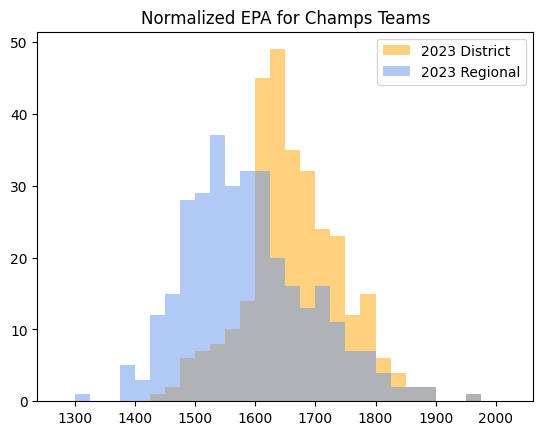

In [ ]:
plt.title(f"Normalized EPA for Champs Teams")
plt.hist(
    [TEAM_TO_EPA_LAST_YEAR[team] for team in ACTUAL_WORLDS_TEAMS_LAST_YEAR.intersection(DISTRICT_TEAMS)],
    bins=30,
    range=(1275, 2025),
    color="orange",
    alpha=0.5,
    label=f"{YEAR-1} District",
)
plt.hist(
    [TEAM_TO_EPA_LAST_YEAR[team] for team in WORLDS_REGIONAL_TEAMS_LAST_YEAR],
    bins=30,
    range=(1275, 2025),
    color="cornflowerblue",
    alpha=0.5,
    label=f"{YEAR-1} Regional",
)
plt.legend()

40.27256164 + 49.2105691 (-0.79145702 + 0.02818625x) +
6.52437784 (-0.79145702 + 0.02818625x)**2


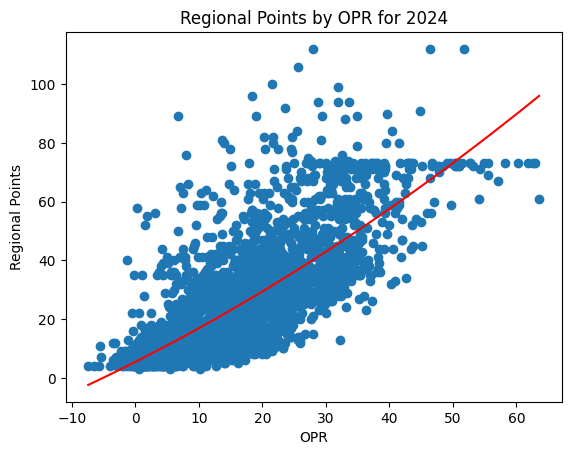

In [ ]:
plt.title(f"Regional Points by OPR for {YEAR}")
x = [team_event.opr for team_events in events_by_team.values() for team_event in team_events]
y = [team_event.regional_points for team_events in events_by_team.values() for team_event in team_events]
plt.scatter(x, y)
trendline_x = numpy.linspace(min(x), max(x), 100)
fit = numpy.polynomial.Polynomial.fit(x, y, 2)
print(fit)
plt.plot(trendline_x, fit(trendline_x), color="red")
plt.xlabel("OPR")
plt.ylabel("Regional Points")